<div style = "text-align: right"> Roger Lee </div>

<left>FINM 32000</left> 
<br>
<left>Spring 2024</left>

<h2><center>Homework # 4</center></h2>
<h3><center><font color = "blue">Solution By: Imtiaz Ali</font></center></h3>

### Note: Only for implied volatility calculation (can comment out if we do not care for it)

In [1]:
%%time
####================================================
### Checking for specific library to make my analysis run
def check_and_install(library_name: list):
    import importlib
    try:
        importlib.import_module(library_name)
        print('{} is already installed.'.format(library_name))
    except ImportError:
        print('{} is not installed. Installing...'.format(library_name))
        !pip install {library_name}
        print('{} has been successfully installed.'.format(library_name))
        
    if library_name == 'py_vollib':
        import numpy as np
        if np.__version__ != '1.23.5':
            print('{} needs numpy version 1.23.5'.format(library_name))
            print("NumPy version Before Update:", np.__version__)
            !pip install --user numpy==1.23.5
            import numpy as np
            print("NumPy version After Update:", np.__version__)
            
            ### Need to restart the Kernal to run properly
            from IPython.display import display_html
            from IPython.display import HTML
            display_html("<script>Jupyter.notebook.kernel.restart()</script>", raw=True)
        else:
            print("NumPy version is:", np.__version__)


####================================================            
### Set parameter to TRUE of FALSE
compute_put_IV_flag = True  ### MAKE False if you do not want to change numpy version to compute IV ###

### Run library check
if compute_put_IV_flag == True:
    libraries_to_check = ['py_vollib']
    for lib in libraries_to_check:
        check_and_install(lib)


py_vollib is already installed.
NumPy version is: 1.23.5
CPU times: total: 125 ms
Wall time: 217 ms


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from typing import Tuple

pd.set_option('display.max_rows', None)
print("NumPy version is:", np.__version__)


NumPy version is: 1.23.5


In [3]:
%%time
####================================================
import sys

### Get Python and Jupyter Notebook version and information
# print('=' * 50)
# print(sys.executable)
print('=' * 50)
print(sys.version)
print('=' * 50)
print(sys.version_info)
print('=' * 50)
!python --version
print('=' * 50)
!jupyter --version
print('=' * 50)


3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=8, micro=12, releaselevel='final', serial=0)
Python 3.8.12
Selected Jupyter core packages...
IPython          : 8.12.0
ipykernel        : 6.19.2
ipywidgets       : 8.0.4
jupyter_client   : 8.1.0
jupyter_core     : 5.3.0
jupyter_server   : 1.13.5
jupyterlab       : 3.3.2
nbclient         : 0.5.13
nbconvert        : 6.1.0
nbformat         : 5.7.0
notebook         : 6.5.4
qtconsole        : 5.4.2
traitlets        : 5.7.1
CPU times: total: 62.5 ms
Wall time: 2.24 s


# Problem 1


> Let $S$ be a futures price. Assume that under risk-neutral probability measure, $S$ has CEV (constant elasticity of variance) dynamics:
$$\text{d}S_{t} = \sigma S_{t}^{1+\alpha}\text{d}W_{t}, \quad S_{0} = 100$$ <br>
where $W$ is Brownian motion under risk neutral probability and with constants $\sigma, \alpha$. The superscript on $S_{t}$ is an exponent (power). The interest rate on the bank account is $r$. The $S$ here is a futures price, so it has drift coefficient $0$. (But prices of European options on $S$ still have drift coefficient $r$).


## Problem 1a


> Let $C(S_{t}, t)$ be the time-$t$ no-arbitrage price of an European put on $S$, with strike $K$ andexpiry $T$. Write down a PDE, with terminal condition, for $C(S, t)$. Leave your answer in terms of $r, \sigma, \alpha, K, T$.

>- Considering a European put $C(S_t,t)$ on $S$ with strike $K$ and expiry $T$, we can use Ito's rule to find the dynamics of $C$, namely:
$$\text{d}f(X_{t},t)=\frac{\partial f}{\partial t}\text{d}t + \frac{\partial f}{\partial X}\text{d}X_{t} + \frac{1}{2}\frac{\partial^{2} f}{\partial X^{2}}(\text{d}X_{t})^{2}$$<br>
where we can substitute $f = C$ and $X_{t} = S_{t}$ to get:
<br><br>
$$\begin{align*}
\text{d}C(S_{t},t) = &\hspace{4mm}\frac{\partial C}{\partial t}\text{d}t + \frac{\partial C}{\partial S}\text{d}S_{t} + \frac{1}{2}\frac{\partial^{2} C}{\partial S^{2}}(\text{d}S_{t})^{2}\\
= &\hspace{4mm} \frac{\partial C}{\partial t}\text{d}t + \frac{\partial C}{\partial S}\bigg(\sigma S_{t}^{1+\alpha}\text{d}W_{t} \bigg) + \frac{1}{2} \frac{\partial^{2} C}{\partial S^{2}}\bigg((\sigma S_{t}^{1+\alpha}\text{d}W_{t})^{2} \bigg)\\
= &\hspace{4mm} \frac{\partial C}{\partial t}\text{d}t + \frac{\partial C}{\partial S}\sigma S_{t}^{1+\alpha}\text{d}W_{t} + \frac{1}{2} \frac{\partial^{2} C}{\partial S^{2}}\sigma^{2} S_{t}^{2(1+\alpha)}\text{d}t \\
= &\hspace{4mm} \bigg(\frac{\partial C}{\partial t} + \frac{1}{2}\sigma^{2} S_{t}^{2(1+\alpha)}\frac{\partial^{2} C}{\partial S^{2}} \bigg)\text{d}t + \sigma S_{t}^{1+\alpha}\frac{\partial C}{\partial S}\text{d}W_{t}\\
\end{align*}$$

>- European options on $S$ are traded securities, the price of $C$ has drift coefficient $r$. Equating this to the drift from above:
$$\frac{\partial C}{\partial t} + \frac{1}{2}\sigma^{2} S_{t}^{2(1+\alpha)}\frac{\partial^{2} C}{\partial S^{2}} = rC$$<br>
$$C(S_{T}, T) = \left(K - S_{T}\right)^{+} = max\left\{0, K - S_{T}\right\}$$<br>
which define the PDE and terminal condition for the pricing function $C(S_{t}, t)$ of a European Put option.

>- We can also relate this to the Crank-Nicolson PDE:
$$\begin{align*}
\frac{\partial C}{\partial t} + f\left(S_{t}, t\right) \frac{\partial^{2} C}{\partial S^{2}_{t}} + g\left(S_{t}, t\right) \frac{\partial C}{\partial S_{t}} + h\left(S_{t}, t\right)C = 0 \\ 
\frac{\partial C}{\partial t} + \frac{1}{2}\sigma^{2}\left(S^{1+\alpha}_{t}\right)^{2} \frac{\partial^{2} C}{\partial S^{2}_{t}} + 0\frac{\partial C}{\partial S_{t}} - rC = 0 \\
\end{align*}$$

>- This can be generalized to having $r_{grow} = 0$ and assuming scaling like GBM, such that:
$$\begin{align*}
f\left(S_{t}, t\right) &= \frac{1}{2}\sigma^{2}S_{t}^{2(1+\alpha)}\ \\ 
g\left(S_{t}, t\right) &= r_{grow}\times S_{t} = 0 \times S_{t} = 0 \\
h\left(S_{t}, t\right) &= -r \\
\end{align*}$$


## Problem 1b


>  Let $r = 0.05$, $\sigma = 3$, $\alpha = −0.5$. Use Crank-Nicolson to find the time-$0$ price of an $\textit{American}$ put on $S$ with strike $K = 100$ and expiry $T = 0.25$. Partial code is provided in the $\text{ipynb}$ file. You may use the boundary conditions implemented in the function <br><br>
$$\text{FD_CrankNicolson.price_put_CEV}$$<br>
> At the low-$S$ boundary, it assumes the put value equals intrinsic value (exercise value). At the high-$S$ boundary, it approximates the put value as zero.<br>
> You may use the FD grid given in the $\text{ipynb}$ file.

>- Let:
>>- $r = 0.05$
>>- $\sigma = 3$
>>- $\alpha = -0.5$
>>- $f^{j}_{n} = f(S_{j}, t_{n}) = \frac{1}{2}\sigma^{2} S_{j}^{2(1+\alpha)} = \frac{9}{2}S_{j}$
>>- $g^{j}_{n} = g(S_{j}, t_{n}) = 0$
>>- $h^{j}_{n} = h(S_{j}, t_{n}) = -r = -0.05 = -\frac{1}{20}$
>- Then the discretized PDE under the Crank-Nicolson scheme is:
$$\frac{C^{j}_{n+1} - C^{j}_{n}}{\Delta t} + \frac{1}{2}\bigg[f^{j}_{n}\frac{C^{j+1}_{n}-2C^{j}_{n}+C^{j-1}_{n}}{(\Delta x)^{2}}+ g^{j}_{n}\frac{C^{j+1}_{n}-C^{j-1}_{n}}{2\Delta x} + h^{j}_{n}C^{j}_{n} \bigg] \\
+ \frac{1}{2}\bigg[f^{j}_{n+1}\frac{C^{j+1}_{n+1}-2C^{j}_{n+1}+C^{j-1}_{n+1}}{(\Delta x)^{2}}+ g^{j}_{n+1}\frac{C^{j+1}_{n+1}-C^{j-1}_{n+1}}{2\Delta x} + h^{j}_{n+1}C^{j}_{n+1} \bigg]$$

>- Then for $j = -J + 1, \cdots, J - 1$ (ignoring the boundaries at $-J$ and $J$):
$$-F^{j}_{n}C^{j+1}_{n} + (1+G^{j}_{n})C^{j}_{n} - H^{j}_{n}C^{j-1}_{n} = F^{j}_{n+1}C^{j+1}_{n+1} + (1-G^{j}_{n+1})C^{j}_{n+1} + H^{j}_{n+1}C^{j-1}_{n+1}$$ <br>
where, in this case, the Crank-Nicolson coefficients are:
$$\begin{align*}
F^{j}_{n} &= \frac{1}{2}\frac{\Delta t}{(\Delta x)^{2}}f^{j}_{n} + \frac{1}{4}\frac{\Delta t}{\Delta x}g^{j}_{n} = \frac{9}{4}\frac{\Delta t}{(\Delta x)^{2}}S_{j} = H^{j}{n} \\
G^{j}_{n} &= \frac{\Delta t}{(\Delta x)^{2}}f^{j}_{n} - \frac{\Delta t}{2}h^{j}_{n} = \frac{9}{2}\frac{\Delta t}{(\Delta x)^{2}} + \frac{\Delta t}{40} \\
H^{j}_{n} &= \frac{1}{2}\frac{\Delta t}{(\Delta x)^{2}}f^{j}_{n} - \frac{1}{4}\frac{\Delta t}{\Delta x}g^{j}_{n} = \frac{9}{4}\frac{\Delta t}{(\Delta x)^{2}}S_{j} = F^{j}{n} \\
\end{align*}$$<br>
and the boundary conditions $C^{J}_{n} = 0$ and $C^{-J}_{n} = K - S_{J}$, assuming sufficiently deep $\text{OTM/ITM}$ at boundary respectively. 

>- The above equation can be written with:
>>- Tri-diagonal matrices, 
$$\begin{align*}A_{n} &= \begin{bmatrix}
1+G^{J-1}_{n} & -H^{J-1}_{n} &  &  &  \\
-F^{J-2}_{n} & 1+G^{J-2}_{n} & -H^{J-2}_{n} &  &  &  \\
& -F^{J-3}_{n} & 1+G^{J-3}_{n} & -H^{J-3}_{n} &  &  \\
& & \cdots & \cdots & \cdots &  \\
& & & -F^{-J+1}_{n} & 1+G^{-J+1}_{n} \\
\end{bmatrix}\\
B_{n+1} &= \begin{bmatrix}
1-G^{J-1}_{n+1} & H^{J-1}_{n+1} &  &  &  \\
F^{J-2}_{n+1} & 1-G^{J-2}_{n+1} & H^{J-2}_{n+1} &  &  &  \\
 & F^{J-3}_{n+1} & 1-G^{J-3}_{n+1} & H^{J-3}_{n+1} &  &  \\
 & & \cdots & \cdots & \cdots &  \\
 & & & F^{-J+1}_{n+1} & 1-G^{-J+1}_{n+1} \\
\end{bmatrix}\end{align*}$$
>>- Unknown and known price vectors,
$$\overrightarrow{C}_{n} = \begin{bmatrix}
C^{J-1}_{n} \\
C^{J-2}_{n} \\
\vdots \\
C^{-J+2}_{n} \\
C^{-J+1}_{n} \\
\end{bmatrix}, \quad
\overrightarrow{C}_{n+1} = \begin{bmatrix}
C^{J-1}_{n+1} \\
C^{J-2}_{n+1} \\
\vdots \\
C^{-J+2}_{n+1} \\
C^{-J+1}_{n+1} \\
\end{bmatrix}$$
>>- Known boundary condition vectors,
$$\overrightarrow{Z}_{n} = \begin{bmatrix}
-F^{J-1}_{n}C^{J}_{n} \\
0 \\
\vdots \\
0 \\
-H^{-J+1}_{n}C^{-J}_{n} \\
\end{bmatrix}, \quad
\overrightarrow{Z}_{n+1} = \begin{bmatrix}
F^{J-1}_{n+1}C^{J}_{n+1} \\
0 \\
\vdots \\
0 \\
H^{-J+1}_{n+1}C^{-J}_{n+1} \\
\end{bmatrix}$$
>>- With the difference in the boundary vector as,
$$\Delta\overrightarrow{Z}_{n+1} = \overrightarrow{Z}_{n+1} - \overrightarrow{Z}_{n} = \begin{bmatrix}
0 \\
0 \\
\vdots \\
0 \\
2H^{-J+1}_{n+1}C^{-J}_{n+1}\\
\end{bmatrix}$$
>- To form the following system of linear equations:
$$A_{n}\overrightarrow{C}_{n} + \overrightarrow{Z}_{n} = B_{n+1}\overrightarrow{C}_{n+1} + \overrightarrow{Z}_{n+1}$$

>- We can solve for $\overrightarrow{C}_{n}$ bt the following:
$$\begin{align*}
A_{n}\overrightarrow{C}_{n} + \overrightarrow{Z}_{n} &= B_{n+1}\overrightarrow{C}_{n+1} + \overrightarrow{Z}_{n+1}\\
A_{n}\overrightarrow{C}_{n} &= B_{n+1}\overrightarrow{C}_{n+1} + \overrightarrow{Z}_{n+1} - \overrightarrow{Z}_{n}\\
A_{n}\overrightarrow{C}_{n} &= B_{n+1}\overrightarrow{C}_{n+1} +\Delta\overrightarrow{Z}_{n+1}\\
\overrightarrow{C}_{n} &= A_{n}^{-1}\left(B_{n+1}\overrightarrow{C}_{n+1} +\Delta\overrightarrow{Z}_{n+1}\right)\\
\end{align*}$$

>- Therefore, the solution to the augmented matrix $\Bigg[A_{n}\Bigg| B_{n+1}\overrightarrow{C}_{n+1} + \Delta\overrightarrow{Z}_{n+1}\Bigg]$, which is computationally less complex, is $\overrightarrow{C}_{n}$.

>- Note:
>>- $\overrightarrow{C}_{n}$ is the time-$n$ put prices that we are trying to solve for via backwards induction
>>- $\overrightarrow{C}_{n+1}$ is the time-$(n+1)$ put prices that we have solved for previously or the given terminal condition
>- The second to last equality from above holds because:
>>- At the upper boundary, we assume the put value as zero, $C^{J}_{n} = C^{J}_{n+1} = 0$, as the option is deep $\text{OTM}$, thus: 
$$F^{J-1}_{n+1}C^{J}_{n+1} + F^{J-1}_{n}C^{J}_{n} = 0$$<br>
>>- At the lower boundary, we assume the put value equals intrinsic value (exercise value), $C^{-J}_{n} = C^{-J}_{n+1} = K - S_{J}$, as the option is deep $\text{ITM}$
>>>- Additionally, we know from above that $H^{-J+1}_{n+1} = H^{-J+1}_{n} = \frac{9}{4}\frac{\Delta t}{(\Delta x)^{2}}$ (in this case, $F^{j}_{n}, G^{j}_{n}, H^{j}_{n}$ are time-independent) 
$$H^{-J+1}_{n+1}C^{-J}_{n+1} + H^{-J+1}_{n}C^{-J}_{n} = 2H^{-J+1}_{n+1}C^{-J}_{n+1}$$
>- For an American put, $C^{j}_{n} = \max\{C^{j}_{n} \in \overrightarrow{C}_{n}, \left(K - S^{j}_{n}\right)^{+}\}$.
>- We will implement the above algorithm in the `FD_CrankNicolson_Engine` function `price_put_CEV`.


In [4]:
%%time
####================================================
### Model Dynamics
class CEV:
    
    def __init__(self, volcoeff: float, alpha: float, rGrow: float, r: float, S0: float) -> None:
        self.volcoeff = volcoeff
        self.alpha = alpha
        self.rGrow = rGrow
        self.r = r
        self.S0 = S0


####================================================
### Contract
class Put:
    
    def __init__(self, T: float, K: float) -> None:
        self.T = T
        self.K = K

        

CPU times: total: 0 ns
Wall time: 0 ns


In [5]:
%%time
####================================================
### Pricing Engine
class FD_CrankNicolson_Engine:

    def __init__(self, SMax: float, SMin: float, deltaS: float, deltat: float) -> None:
        self.SMax = SMax
        self.SMin = SMin
        self.deltaS = deltaS
        self.deltat = deltat
        
        
    def price_put_CEV(self, contract: Put, dynamics: CEV) -> Tuple[np.ndarray, np.ndarray]:
        ### returns array of all initial spots,
        ### and the corresponding array of put prices
        volcoeff, alpha, rGrow, r, S0 = dynamics.__dict__.values()

        ### SMin and SMax denote the smallest and largest S in the _interior_.
        ### The boundary conditions are imposed one level _beyond_,
        ### e.g. at S_lowboundary=SMin-deltaS, not at SMin.
        ### To relate to lecture notation, S_lowboundary is S_{-J}
        ### whereas SMin is S_{-J+1}
        N = round(contract.T / self.deltat)
        if abs(N - contract.T / self.deltat) > 1e-12:
            raise ValueError('Bad time step')
        numS = round((self.SMax - self.SMin) / self.deltaS) + 1
        if abs(numS - (self.SMax - self.SMin) / self.deltaS - 1) > 1e-12:
            raise ValueError('Bad time step')
        
        ### 'S': The FIRST indices in this array are for HIGH levels of S {J-1,.., 0,...,-J+1}
        ### 'S_lowboundary': Assumes the put value equals intrinsic value (exercise value)
        S = np.linspace(self.SMax, self.SMin, numS)
        S_lowboundary = self.SMin - self.deltaS
        
        ### Put payoff
        putprice = np.maximum(contract.K - S, 0)
        
        ### Crank-Nicolson FD Construction
        ### Assign given PDE coefficients (An array of the same size as S)
        ratio1 = self.deltat / self.deltaS
        ratio2 = self.deltat / self.deltaS**2
        f = (1 / 2) * (volcoeff ** 2) * (S ** (2 * (1 + alpha))) 
        g = rGrow * S                         ### Will account for BS-Dynamics 
        h = -r * np.ones(np.size(S))          ### A scalar can be acceptable here
        ### Crank-Nicolson coefficients
        F = (0.5 * ratio2 * f) + (0.25 * ratio1 * g)      # F(j,n)= (1/2)*(dt / ds^2)*f(j,n) + (1/4)*(dt/ds)*g(j,n)
        G =       (ratio2 * f) - (0.50 * self.deltat * h) # G(j,n)=       (dt / ds^2)*f(j,n) - (1/2)*(dt)*h(j,n)
        H = (0.5 * ratio2 * f) - (0.25 * ratio1 * g)      # H(j,n)= (1/2)*(dt / ds^2)*f(j,n) - (1/4)*(dt/ds)*g(j,n)
        
        ### Construct Tri-Diagonal LHS and RHS Matrix to solve Crank-Nicolson system of equations
        ### NOTE: scipy.sparse.diags creates SPARSE matrices
        LHSmatrix = diags([-H[:-1], 1 + G, -F[1:]], [1, 0, -1], shape=(numS, numS), format="csr") ### LHS matrix
        RHSmatrix = diags([H[:-1], 1 - G, F[1:]], [1, 0, -1], shape=(numS, numS), format="csr")   ### RHS matrix
        
        ### Induct backwards to time 0, updating the optionprice array
        tn = np.arange(N-1, -1, -1)*self.deltat
        for t in tn:
            ### Make known RHS vector
            rhs = RHSmatrix * putprice

            ### Now let's add the boundary condition vectors.
            ### They are nonzero only in the last component:
            ### NOTE: below calculation is the simplified result when moving LHS boundary condition to RHS
            rhs[-1] = rhs[-1] + 2 * H[-1] * (contract.K - S_lowboundary)

            putprice = spsolve(LHSmatrix, rhs)
            # numpy.linalg.solve, which expects arrays as inputs,
            # is fine for small matrix equations, and for matrix equations without special structure.
            # But for large matrix equations in which the matrix has special structure,
            # we may want a more intelligent solver that can run faster
            # by taking advantage of the special structure of the matrix.
            # Specifically, in this case, let's try to use a solver that recognizes the SPARSE MATRIX structure.
            # Try spsolve, imported from scipy.sparse.linalg
            
            ### Apply American Put Payoff
            putprice = np.maximum(putprice, contract.K - S)

        return (S, putprice)
    

CPU times: total: 0 ns
Wall time: 0 ns


In [6]:
%%time
####================================================
### Set Model Dynamics and Contract
hw4dynamics = CEV(volcoeff=3, alpha=-0.5, rGrow=0, r=0.05, S0=100)
hw4contract = Put(T=0.25, K=100)


CPU times: total: 0 ns
Wall time: 0 ns


In [7]:
%%time
####================================================
### Calculating time-0 future prices for various S0, using CEV Dynamics:
hw4FD = FD_CrankNicolson_Engine(SMax=200, SMin=50, deltaS=0.1, deltat=0.0005)
(S0_all, putprice) = hw4FD.price_put_CEV(hw4contract, hw4dynamics)

### pricer_put_CEV_CrankNicolson gives us option prices for ALL S0 from SMin to SMax
### But let's display only for a few S0 near 100:
### Format to display as dataframe
displayStart = hw4dynamics.S0 - hw4FD.deltaS * 1.5
displayEnd = hw4dynamics.S0 + hw4FD.deltaS * 1.5
displayrows = (S0_all > displayStart) & (S0_all < displayEnd)
np.set_printoptions(precision=4, suppress=True, formatter={'float_kind':'{:f}'.format})

### Store into dataframe
# print(np.stack((S0_all, putprice),axis=1)[displayrows])
putprices = pd.DataFrame(np.stack((S0_all, putprice), axis=1)[displayrows]).set_index(0)
putprices.columns = ['CEV Crank-Nicolson']

### Format dataframe and show results
putprices.index = putprices.index.format(formatter=lambda x: '{:.2f}'.format(x))
putprices.index.name = 'S0'
putprices.style.format(formatter=lambda x: '{:.4f}'.format(x))


CPU times: total: 312 ms
Wall time: 322 ms


,CEV Crank-Nicolson
S0,
100.10,5.8704
100.00,5.9183
99.90,5.9665


## Problem 1c


> Compute numerically the time-$0$ delta and gamma of the put in (b).

>- I will use the following equations (evaluated at time t = 0):
$$\Delta = \frac{\partial P}{\partial S} \approx \frac{P\left(S_{t} + \Delta S, t\right) - P\left(S_{t} - \Delta S, t\right)}{2\Delta S}$$<br>
$$\Gamma = \frac{\partial^{2} P}{\partial S^{2}} \approx \frac{P\left(S_{t} + \Delta S, t\right) - 2P\left(S_{t}, t\right)  + P\left(S_{t} - \Delta S, t\right)}{\left(\Delta S\right)^{2}}$$<br>
$$\Theta = \frac{\partial P}{\partial t} \approx \frac{P\left(S_{t}, t + \Delta t\right) - P\left(S_{t}, t\right)}{\Delta t} = \frac{P\left(S_{t}, t + \Delta t\right) - P\left(S_{t}, t - \Delta t\right)}{2\Delta t}$$


In [8]:
%%time
####================================================
### Compute Delta and Gamma for time-0
deltaS = hw4FD.deltaS
P2 = putprices.loc['100.10', 'CEV Crank-Nicolson']  ### S = 100.10, P = 5.8704 
P0 = putprices.loc['100.00', 'CEV Crank-Nicolson']  ### S = 100.00, P = 5.9183
P1 = putprices.loc['99.90', 'CEV Crank-Nicolson']   ### S = 99.90, P = 5.9665

Delta = (P2 - P1) / (2*deltaS)
Gamma = (P2 - 2*P0 + P1) / (deltaS**2)
print('The time-0 American Put delta = {:.5f}'.format(Delta))
print('The time-0 American Put gamma = {:.5f}'.format(Gamma))


The time-0 American Put delta = -0.48064
The time-0 American Put gamma = 0.02640
CPU times: total: 0 ns
Wall time: 0 ns


### Problem 1c: Testing Derivative Methods

In [9]:
%%time
####================================================
### Function to calculate Delta and Gamma using Finite Difference accounting for one-sided
def calculate_delta_gamma_FD(putprice: np.ndarray, S0: np.ndarray, 
                             contract: Put, dynamics: CEV, iv_flag: bool = False) -> pd.DataFrame:
    ### Compute the spacing between adjacent points 
    ds = np.diff(S0)

    ### Compute forward finite difference for the first element
    d1forward_fd_first = (putprice[1] - putprice[0]) / ds[0]
    d2forward_fd_first = (2*putprice[0] - 5*putprice[1] + 4*putprice[2] - putprice[3]) / (ds[0]**2)

    ### Compute central finite difference for interior points
    d1central_fd_interior = (putprice[2:] - putprice[:-2]) / (2*ds[:-1])
    d2central_fd_interior = (putprice[2:] - 2*putprice[1:-1] + putprice[:-2]) / (ds[:-1]*ds[1:])

    ### Compute backward finite difference for the last element
    d1backward_fd_last = (putprice[-1] - putprice[-2]) / ds[-1]
    d2backward_fd_last = (2*putprice[-1] - 5*putprice[-2] + 4*putprice[-3] - putprice[-4]) / (ds[-1]**2)

    ### Combine all differences
    delta = np.concatenate(([d1forward_fd_first], d1central_fd_interior, [d1backward_fd_last]))
    gamma = np.concatenate(([d2forward_fd_first], d2central_fd_interior, [d2backward_fd_last]))
    
    ### Checking to see if we want implied volatility
    if iv_flag == False:
        df_FD = pd.DataFrame(np.column_stack([S0, putprice, delta, gamma]), 
                             columns=['S0', 'putprice', 'delta', 'gamma']).sort_values(by=['S0'])
        df_FD.reset_index(drop=True, inplace=True)
    else:
        from py_vollib.black_scholes.implied_volatility import implied_volatility
        iv_put = []
        for P, S in zip(putprice, S0):
            iv_put.append(implied_volatility(price=P, S=S, K=contract.K, t=contract.T, r=dynamics.r, flag='p'))
        df_FD = pd.DataFrame(np.column_stack([S0, putprice, iv_put, delta, gamma]), 
                             columns=['S0', 'putprice', 'iv_put', 'delta', 'gamma']).sort_values(by=['S0'])
        df_FD.reset_index(drop=True, inplace=True)
        
    return df_FD

    
####================================================
### Function to calculate Delta and Gamma using numpy gradient method
def calculate_delta_gamma_grad(putprice: np.ndarray, S0: np.ndarray, 
                               contract: Put, dynamics: CEV, iv_flag: bool = False) -> pd.DataFrame:
    delta = np.gradient(putprice, S0, edge_order=2)
    gamma = np.gradient(delta, S0, edge_order=2)
    
    ### Checking to see if we want implied volatility
    if iv_flag == False:
        df_grad = pd.DataFrame(np.column_stack([S0, putprice, delta, gamma]), 
                               columns=['S0', 'putprice', 'delta', 'gamma']).sort_values(by=['S0'])
        df_grad.reset_index(drop=True, inplace=True)
    else:
        from py_vollib.black_scholes.implied_volatility import implied_volatility
        iv_put = []
        for P, S in zip(putprice, S0):
            iv_put.append(implied_volatility(price=P, S=S, K=contract.K, t=contract.T, r=dynamics.r, flag='p'))
        df_grad = pd.DataFrame(np.column_stack([S0, putprice, iv_put, delta, gamma]), 
                               columns=['S0', 'putprice', 'iv_put', 'delta', 'gamma']).sort_values(by=['S0'])
        df_grad.reset_index(drop=True, inplace=True)

    return df_grad


####================================================
### Function to plot put price and greeks
def data_plot_put_price_and_greeks(df: pd.DataFrame, iv_flag: bool = False) -> None:
    ### Make X-data and Y-data
    if iv_flag == False:
        x_data = [df.S0, df.S0, df.S0, df.delta, df.delta, df.putprice]
        y_data = [df.putprice, df.delta, df.gamma, df.putprice, df.gamma, df.gamma]
        titles = ['Put Price vs S0', 'Delta vs S0', 'Gamma vs S0', 
                  'Put Price vs Delta', 'Gamma vs Delta', 'Gamma vs Put Price']
        ### Create subplots
        fig, axs = plt.subplots(3, 2, figsize=(10, 8))
    else:
        x_data = [df.S0, df.S0, df.S0, df.delta, df.delta, df.iv_put, df.S0, df.iv_put]
        y_data = [df.putprice, df.delta, df.gamma, df.putprice, df.gamma, df.delta, df.iv_put, df.putprice]
        titles = ['Put Price vs S0', 'Delta vs S0', 'Gamma vs S0', 
                  'Put Price vs Delta', 'Gamma vs Delta', 'Delta vs IV',
                  'Put IV vs S0', 'Put Price vs IV']
        ### Create subplots
        fig, axs = plt.subplots(4, 2, figsize=(10, 16))

    ### Plotting data on each subplot
    for i, ax in enumerate(axs.flat):
        ax.plot(x_data[i], y_data[i])
        ax.set_title(titles[i])

    ### Adjust layout and Display
    plt.tight_layout()
    plt.show()



CPU times: total: 0 ns
Wall time: 0 ns


#### Problem 1c: Finite Difference Method

,S0,putprice,iv_put,delta,gamma
190,69.0,31.000000,0.580705,-1.000000,0.000000e+00
191,69.1,30.900000,0.578892,-1.000000,0.000000e+00
192,69.2,30.800000,0.577080,-1.000000,0.000000e+00
193,69.3,30.700000,0.575271,-1.000000,-2.842171e-12
194,69.4,30.600000,0.573463,-1.000000,2.842171e-12
195,69.5,30.500000,0.571658,-1.000000,0.000000e+00
196,69.6,30.400000,0.569854,-1.000000,0.000000e+00
197,69.7,30.300000,0.568052,-0.999700,5.990009e-03
198,69.8,30.200060,0.566260,-0.998770,1.262898e-02
199,69.9,30.100246,0.564487,-0.997928,4.204904e-03


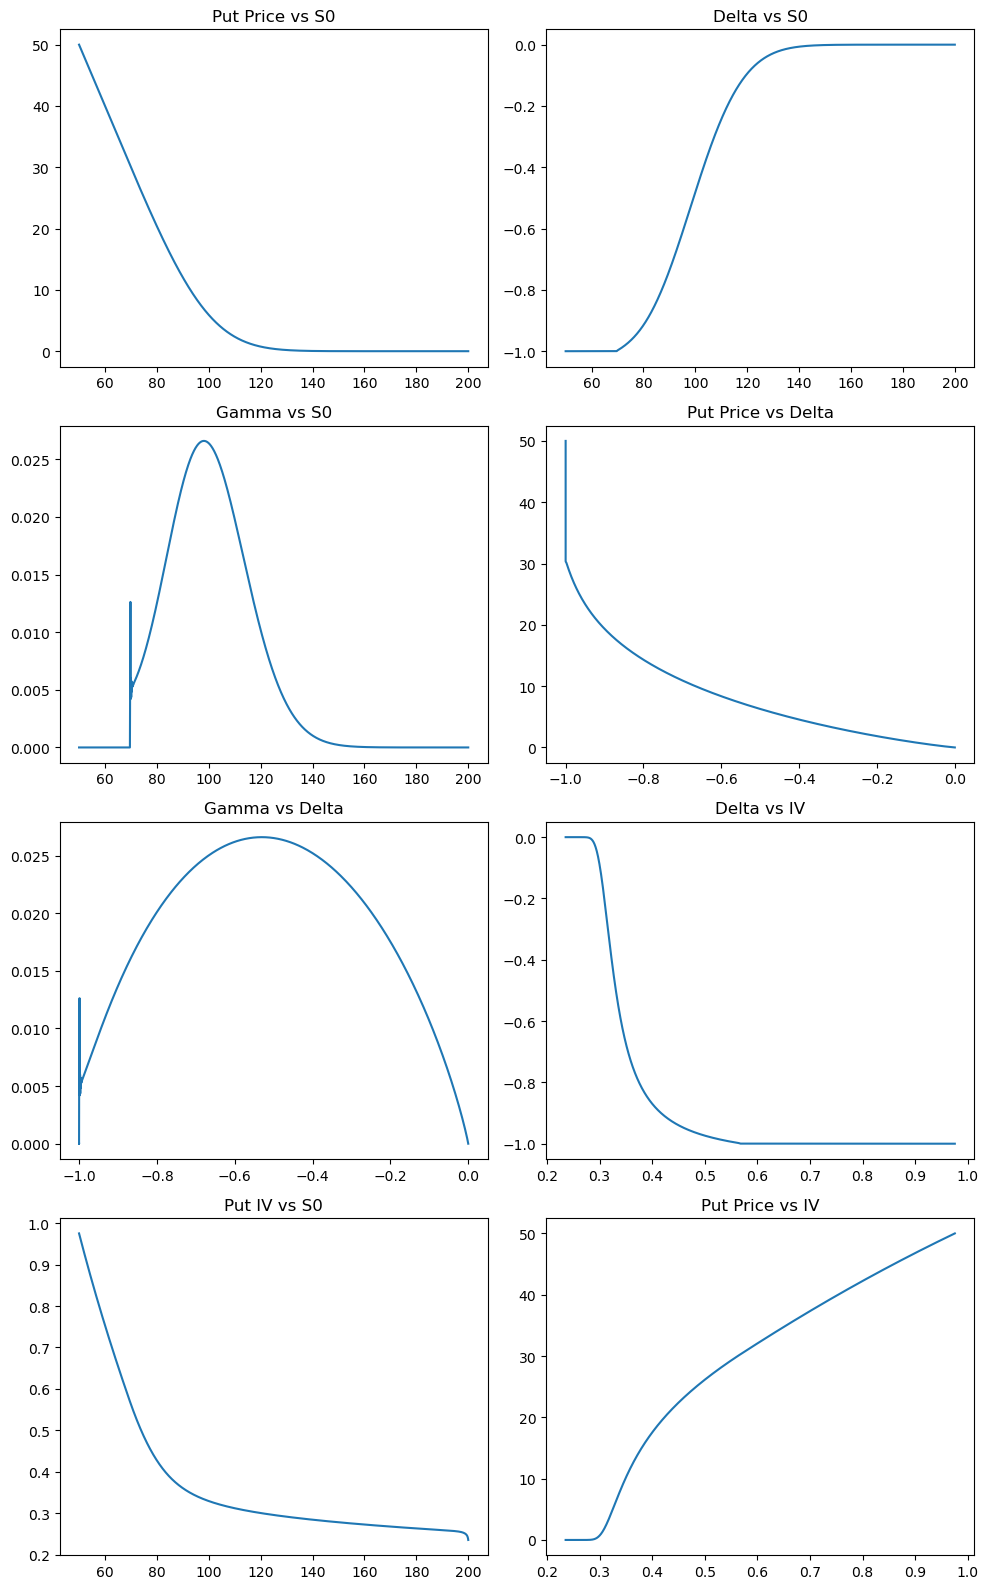

CPU times: total: 1.41 s
Wall time: 1.83 s


In [10]:
%%time
####================================================
### Run Delta and Gamma calculation using finite difference method
compute_put_IV = compute_put_IV_flag ### MAKE False if you do not care to test IV ###
df_FD = calculate_delta_gamma_FD(putprice, S0_all, hw4contract, hw4dynamics, iv_flag=compute_put_IV)
display(df_FD[190:201].head(10))

### Show plots
data_plot_put_price_and_greeks(df_FD, iv_flag=compute_put_IV)


#### Problem 1c: Numpy Gradient Method

,S0,putprice,iv_put,delta,gamma
190,69.0,31.000000,0.580705,-1.000000,0.000000e+00
191,69.1,30.900000,0.578892,-1.000000,0.000000e+00
192,69.2,30.800000,0.577080,-1.000000,0.000000e+00
193,69.3,30.700000,0.575271,-1.000000,1.421085e-13
194,69.4,30.600000,0.573463,-1.000000,0.000000e+00
195,69.5,30.500000,0.571658,-1.000000,-1.421085e-13
196,69.6,30.400000,0.569854,-1.000000,1.497502e-03
197,69.7,30.300000,0.568052,-0.999700,6.152250e-03
198,69.8,30.200060,0.566260,-0.998770,8.863219e-03
199,69.9,30.100246,0.564487,-0.997928,6.760395e-03


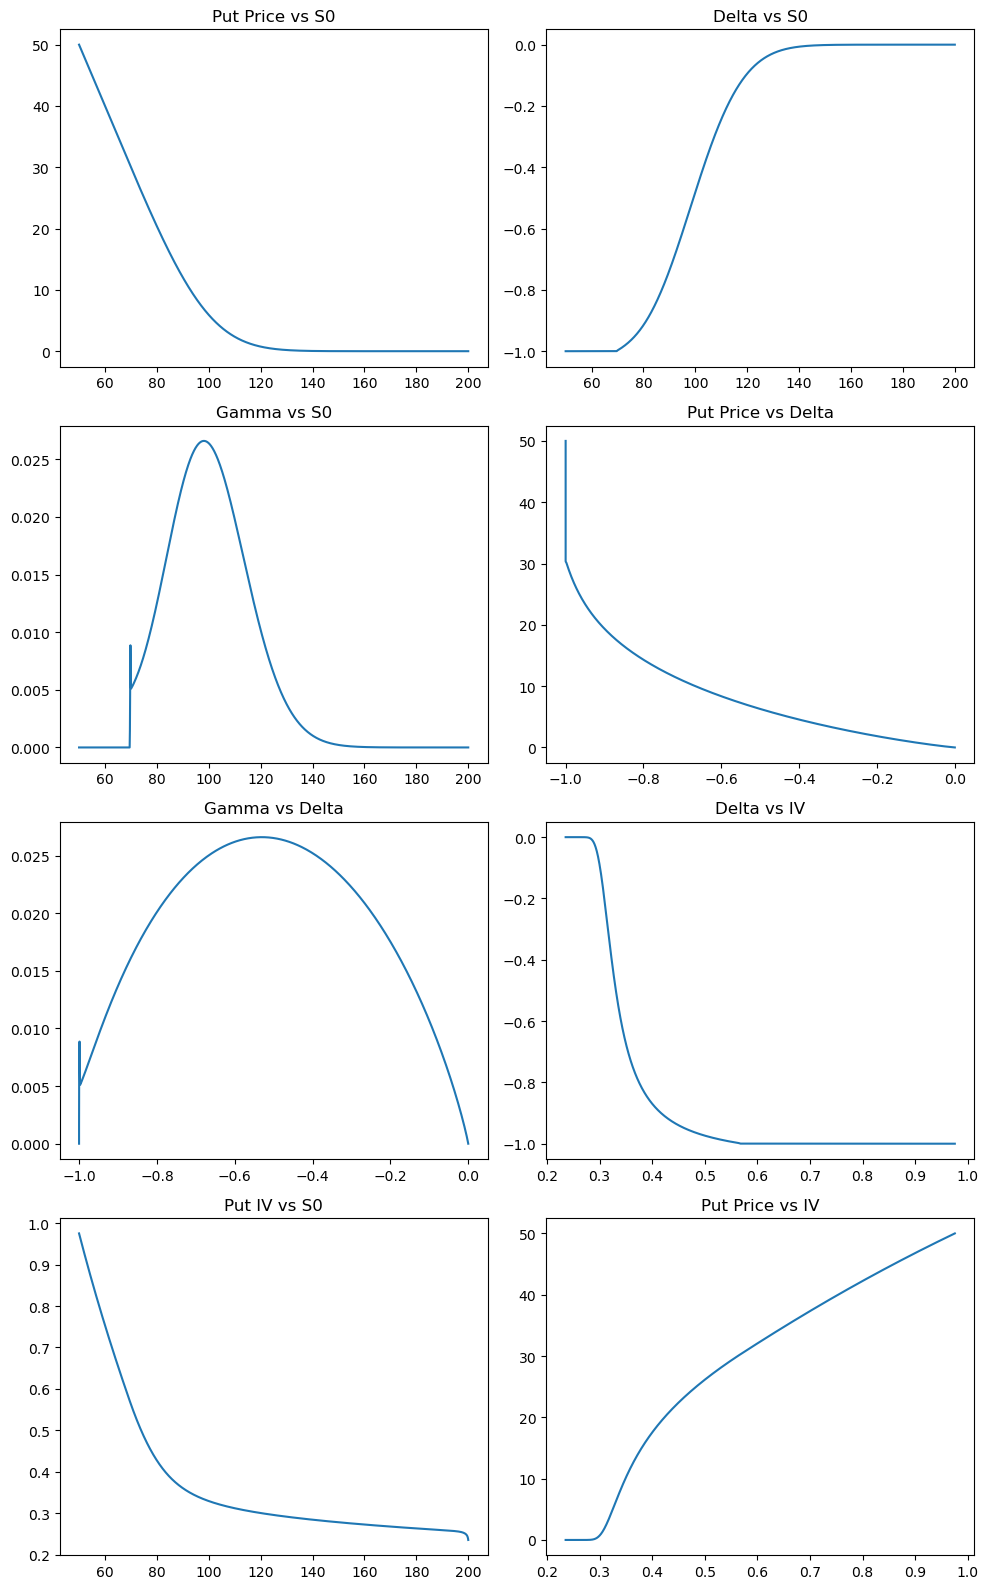

CPU times: total: 859 ms
Wall time: 861 ms


In [11]:
%%time
####================================================
### Run Delta and Gamma calculation using gradient method
compute_put_IV = compute_put_IV_flag ### MAKE False if you do not care to test IV ###
df_grad = calculate_delta_gamma_grad(putprice, S0_all, hw4contract, hw4dynamics, iv_flag=compute_put_IV)
display(df_grad[190:201].head(10))

### Show plots
data_plot_put_price_and_greeks(df_grad, iv_flag=compute_put_IV)



>- Justifying the jump in gamma and the kink in delta:
>- If you consider when is it optimal to exercise early and take the cash we can consider when the underlying price falls.
>- In our case, we have the premium price (continuation value) and the early exercise (intrinsic). Think of the intrinsic as the exercise barrier.
>- Deep ITM Put favors early exercise over holding.
>- If we cross the barriers (decreasing underlying value), the option behaves like a short position in the stock.
>- If it's just a short position, we have a linear relationship, so its delta is exactly -1 and gamma is 0.
>- So when the underlying crosses through this barrier, the gamma jump occurs.
>- Making a closed-form solution, if possible, is beyond the scope of this course and it will involve complex mathematics.
>- In the CEV model with $(1 + \alpha) < 1$, the decreasing volatility with increasing asset price can lead to a situation where the option's intrinsic value increases at a slower rate compared to the Black-Scholes model (where volatility is constant). Consequently, there might be instances where the time value of the option decreases at a faster rate, making early exercise more attractive.
>- In the presence of decreasing volatility, $(1 + \alpha) < 1$, early exercise may be more attractive compared to situations with constant volatility, especially for deep ITM options where the option's intrinsic value dominates its time value, which is the case we have here. 


## Problem 1d


> Using exactly the same $\text{FD_CrankNicolson.price_put_CEV}$ function as in (b) – meaning that you can change the input passed into the function, but cannot change the function’s code – find the time-$0$ price of the American put in (b), but assuming $\textit{Black-Scholes}$ dynamics for $S$ with volatility $0.30$ and interest rate $0.05$ and $S_{0} = 100$. 

>- Now assuming Black-Scholes dynamics for $S$:
$$\text{d}S_{t} = r_{Grow}S_{t}\text{d}t + \sigma S_{t}\text{d}W_{t}$$
>- Since $S$ is a futures price, $r_{Grow} = 0$,
$$\text{d}S_{t} = \sigma S_{t}\text{d}W_t$$
>- With $\sigma = 0.30$ and $r = 0.05$, this corresponds to $\alpha = 0$ and volatility coefficient $\sigma = 0.30$ (not $\sigma = 3$ anymore) in the CEV dynamics, so we can plug this in and use the same CEV pricing as before.


In [12]:
%%time
####================================================
### Calculating time-0 future prices for various S0, using Black-Scholes Dynamics:
### Rgrow = r, since we have BS-dyanmics and non-dividend paying
hw4dynamics = CEV(volcoeff=0.3, alpha=0, rGrow=0.05, r=0.05, S0=100)
(S0_all, putprice) = hw4FD.price_put_CEV(hw4contract, hw4dynamics)

### Format to display as dataframe
displayStart = hw4dynamics.S0 - hw4FD.deltaS * 1.5
displayEnd = hw4dynamics.S0 + hw4FD.deltaS * 1.5
displayrows = (S0_all > displayStart) & (S0_all < displayEnd)
np.set_printoptions(precision=4, suppress=True, formatter={'float_kind':'{:f}'.format})

### Store into dataframe
putprices_BS = pd.DataFrame(np.stack((S0_all, putprice), axis=1)[displayrows]).set_index(0)
putprices_BS.columns = ['Black-Scholes Crank-Nicolson']

### Format dataframe and show results
putprices_BS.index = putprices_BS.index.format(formatter=lambda x: '{:.2f}'.format(x))
putprices_BS.index.name = 'S0'
putprices_BS.style.format(formatter=lambda x: '{:.4f}'.format(x))


CPU times: total: 234 ms
Wall time: 234 ms


,Black-Scholes Crank-Nicolson
S0,
100.10,5.3973
100.00,5.4420
99.90,5.4870


### Problem 1d: Testing Derivative Methods

,S0,putprice,iv_put,delta,gamma
285,78.5,21.500000,0.415908,-1.000000,0.000000e+00
286,78.6,21.400000,0.414238,-1.000000,0.000000e+00
287,78.7,21.300000,0.412569,-1.000000,7.105427e-14
288,78.8,21.200000,0.410901,-1.000000,0.000000e+00
289,78.9,21.100000,0.409234,-1.000000,7.937048e-03
290,79.0,21.000000,0.407567,-0.998413,2.506732e-02
291,79.1,20.900317,0.405935,-0.994987,3.062865e-02
292,79.2,20.801003,0.404342,-0.992287,2.231757e-02
293,79.3,20.701860,0.402767,-0.990523,1.804254e-02
294,79.4,20.602898,0.401210,-0.988678,1.864659e-02


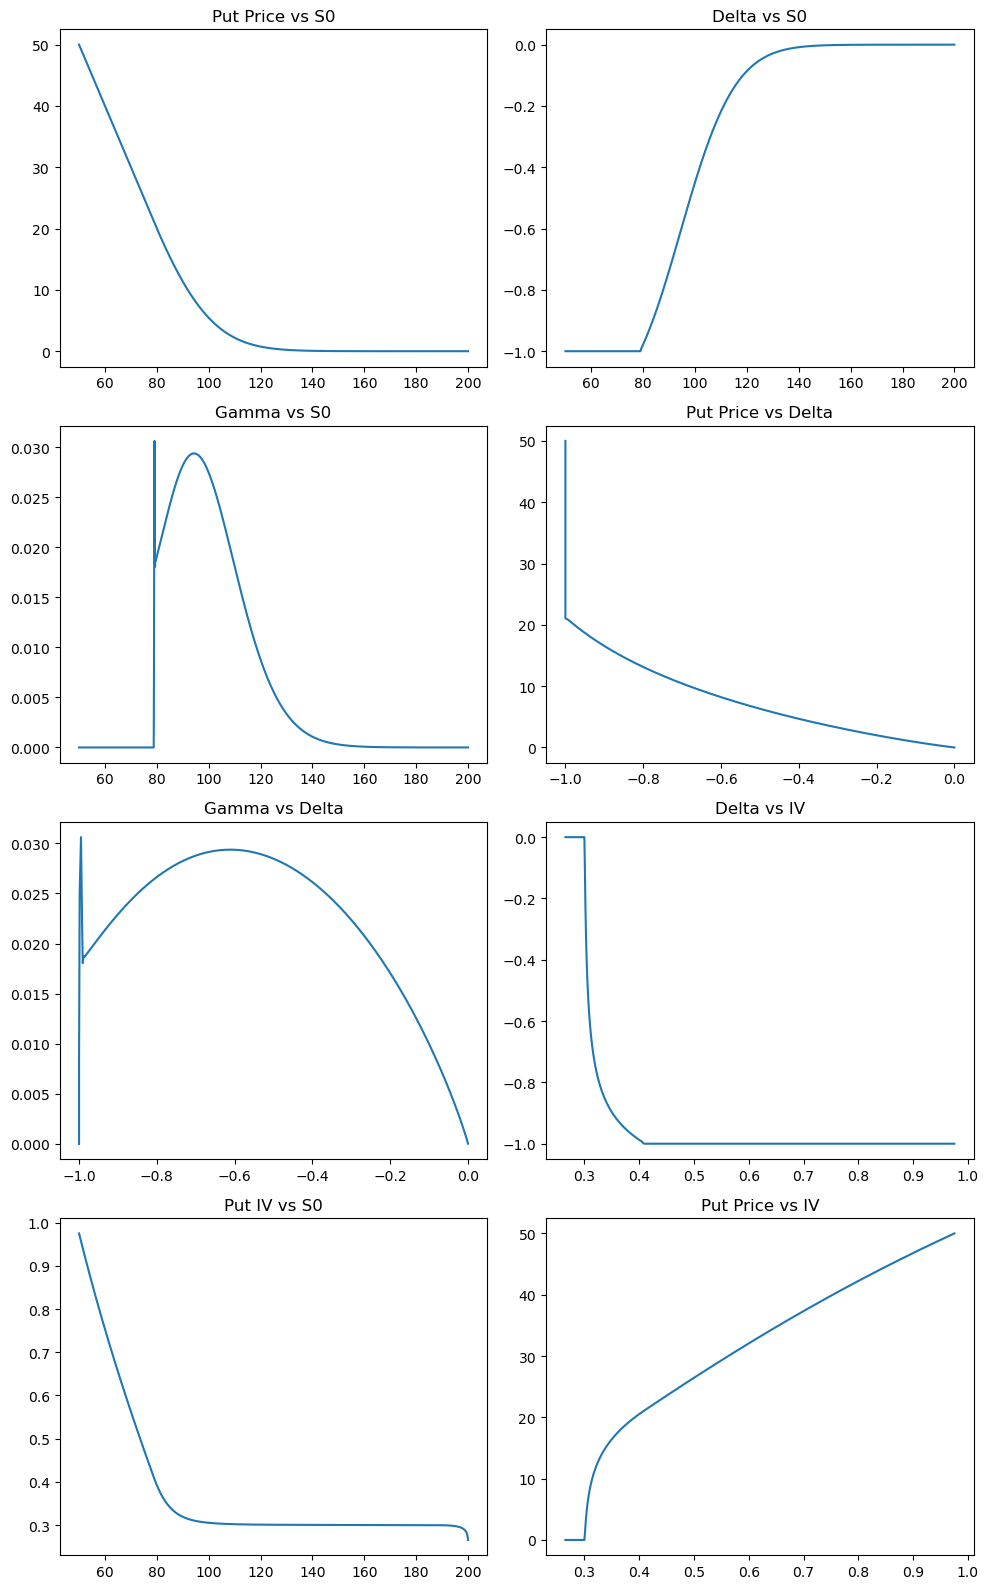

CPU times: total: 781 ms
Wall time: 788 ms


In [13]:
%%time
####================================================
### Run Delta and Gamma calculation using gradient method
compute_put_IV = compute_put_IV_flag ### MAKE False if you do not care to test IV ###
df_grad = calculate_delta_gamma_grad(putprice, S0_all, hw4contract, hw4dynamics, iv_flag=compute_put_IV)
display(df_grad[285:296].head(10))

### Show plots
data_plot_put_price_and_greeks(df_grad, iv_flag=compute_put_IV)



>- Here, we have that $(1 + \alpha) = 1$
>- We have similar behavior as we did when $(1 + \alpha) < 1$.
>- Thus, early exercise may be more attractive for deep ITM options where the option's intrinsic value dominates its time value, which is the case we have here.


# Problem 2


> Playing no-limit hold 'em (in a cash game, not a tournament), Jamie is all-in on the turn, and Patrik has called. Given the $8$ cards that have been revealed ($4$ pocket, $4$ on the board), Patrik is ahead, but Jamie does have $10$ outs. There is no chance of a tie. If you are not familiar with poker, you can ignore all of the above, and just start reading at the next sentence:

> In other words: there are $44$ unrevealed cards, of which $10$ would make Jamie the better hand, and the other $34$ would make Patrik the better hand.

> At this stage, the usual procedure is that one more card will be revealed. If the card is one of the $10$ that favor Jamie, then Patrik collects $0\%$ of the money in the pot. If it is one of the $34$ that favor Patrik, then Patrik collects $100\%$ of the money in the pot. (The dollar value of the pot has been finalized; it does not matter in this problem, what value it is.)



## Problem 2a


> Find the expectation and standard deviation of the fraction of the pot that Patrik will collect, when the last card (the "river") is dealt in the usual way.

>- We can treat this as Bernoulli because either Patrik wins or loses.
>- We can generalize this to Binomial Distribution with $n = 1$ as the number of trials, and let the $X \in [0, 1]$ represent the fractional amount of the pot he wins.
$$\mathbb{P}\left(X = 1\right) = p = \frac{34}{44}$$
$$\mathbb{P}\left(X = 0\right) = q = \frac{10}{44}$$

>- For a Binomial Distribution, we have that:

$$\mathbb{E}\left[X\right] = x\cdot p = 1\cdot\frac{34}{44} = 0.77273$$
$$\mathrm{Var}\left[X\right] = \sigma^{2}\left[X\right] = \mathbb{E}\left[X^{2}\right] - \left(\mathbb{E}\left[X\right]\right)^{2} = x^{2}\cdot p\cdot q = \frac{34}{44}\frac{10}{44} = 0.17562$$
$$\mathrm{Std}\left[X\right] = \sigma\left[X\right] = \sqrt{\mathrm{Var}\left[X\right]} = x\cdot\sqrt{p\cdot q} = x\cdot\sqrt{p\cdot q} = 0.41907$$


## Problem 2b


> Suppose that, before the river is dealt, Jamie and Patrik agree to "run it three times," with replacement (Replacement is not actually done in practice. Running it twice, or three times, or four times, is conventionally
done $\textit{without}$ replacement. So part (c) is more realistic). This means that the last card will be dealt three times, with replacement and reshuffling after each deal of that card. For each of the three iterations of the river card, whoever wins with that card gets one-third of the pot. Therefore Patrik will win either $0\%$, or $1/3$, or $2/3$, or $100\%$ of the full pot, depending on whether $0$, $1$, $2$, or $3$ of the cards to be dealt turn out to favor Patrik.

> Find the expectation and standard deviation of the fraction of the pot that Patrik will collect.

>- We can generalize this to Binomial Distribution with $n$ as the number of trials, and let the $X_{i} \in [0, 1]$ represent the fractional amount of the pot he wins. 
>- Here, since we assume replacement and that $X_{i}$ are IID, we get the following:
$$\mathbb{P}\left(X = 1\right) = p = \frac{34}{44}$$
$$\mathbb{P}\left(X = 0\right) = q = \frac{10}{44}$$

>- For a Binomial Distribution, we have that, for each $X_{i}$ due to IID:

$$\mathbb{E}\left[X_{i}\right] = x\cdot p = \frac{1}{3}\frac{34}{44} = 0.25758$$
$$\mathrm{Var}\left[X_{i}\right] = x^{2}\cdot p\cdot q = \left(\frac{1}{3}\right)^{2}\frac{34}{44}\frac{10}{44} = 0.01951$$
$$\mathrm{Std}\left[X_{i}\right] = \sqrt{\mathrm{Var}\left[X_{i}\right]} = x\cdot\sqrt{p\cdot q} = 0.13969$$


>- For the total expectation, with $n = 3$, **WITH REPLACEMENT**:

$$\mathbb{E}\left[X\right] = \mathbb{E}\left[X_{1}\right] + \mathbb{E}\left[X_{2}\right] + \mathbb{E}\left[X_{3}\right] = = x\cdot n\cdot p = 3\frac{1}{3}\frac{34}{44} = 0.77273$$
$$\mathrm{Var}\left[X\right] = \mathrm{Var}\left[X_{1}\right] + \mathrm{Var}\left[X_{2}\right] + \mathrm{Var}\left[X_{3}\right] = x^{2}\cdot n\cdot p\cdot q = 3\left(\frac{1}{3}\right)^{2}\frac{34}{44}\frac{10}{44} = 0.05854$$
$$\mathrm{Std}\left[X\right] = \sqrt{\mathrm{Var}\left[X\right]} = x\cdot\sqrt{n\cdot p\cdot q} = 0.24195$$


## Problem 2c


> Same question as (b) but $\textit{without}$ replacement after each deal of the river card. Is the standard deviation larger or smaller than the standard deviation in part (b), and does that make sense?

>- We need the probabilities of Patrik winning $X = 0, 1, 2, 3$ runs.
>- We can use the Hypergeometric distribution.
>- The corresponding payout (fractional of total pot) for each $X$ is $0, \frac{1}{3}, \frac{2}{3}, 1$, respectively.
$$\mathbb{P}\left(X = 0\right) = \frac{\binom{34}{0}\binom{10}{3}}{\binom{44}{3}} = 0.00906$$
$$\mathbb{P}\left(X = 1\right) = \frac{\binom{34}{1}\binom{10}{2}}{\binom{44}{3}} = 0.11552$$
$$\mathbb{P}\left(X = 2\right) = \frac{\binom{34}{2}\binom{10}{1}}{\binom{44}{3}} = 0.42359$$
$$\mathbb{P}\left(X = 3\right) = \frac{\binom{34}{3}\binom{10}{0}}{\binom{44}{3}} = 0.45183$$

>- For the total expectation, with $n = 3$, **WITHOUT REPLACEMENT**:
$$\mathbb{E}\left[X\right] = 0\mathbb{P}\left(X = 0\right) + \frac{1}{3}\mathbb{P}\left(X = 1\right) + \frac{2}{3}\mathbb{P}\left(X = 2\right) + 1\mathbb{P}\left(X = 3\right) = 0.77273$$
$$\mathbb{E}\left[X^{2}\right] = 0^{2}\mathbb{P}\left(X = 0\right) + \left(\frac{1}{3}\right)^{2}\mathbb{P}\left(X = 1\right) + \left(\frac{2}{3}\right)^{2}\mathbb{P}\left(X = 2\right) + 1^{2}\mathbb{P}\left(X = 3\right) = 0.65292$$
$$\mathrm{Var}\left[X\right] = \mathbb{E}\left[X^{2}\right] - \left(\mathbb{E}\left[X\right]\right)^{2} = 0.05582$$
$$\mathrm{Std}\left[X\right] = \sqrt{\mathrm{Var}\left[X\right]} = 0.23626$$

>- **Comparing:**
>>- In part (b) **WITH REPLACEMENT**, we have $\mathrm{Std}\left[X\right] = 0.24195$
>>- In part (c) **WITHOUT REPLACEMENT**, we have $\mathrm{Std}\left[X\right] = 0.23626$
>>- So the standard deviation is smaller in (c) than in (b).
>>- In the case of no replacement, the expected payout is dependent on the events now, so the covariance is not zero.
>>- Thus, an adjustment to the standard deviation occurs since we decrease the samples size.
>>- This adjustment causes the standard deviation of without replacement to be smaller than with replacement.
>>- In the limit of large sampling, the covariance will approach zero, so with and without replacement would be similar.
